## 9.1 U-Net

In [1]:
import torch
from torch import nn

In [2]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )

    def forward(self, x):
        return self.convs(x)

In [3]:
class UNet(nn.Module):
    def __init__(self, in_ch=1):
        super().__init__()
        
        self.down1 = ConvBlock(in_ch, 64)
        self.down2 = ConvBlock(64, 128)
        self.bot1 = ConvBlock(128, 256)
        self.up2 = ConvBlock(128 + 256, 128)
        self.up1 = ConvBlock(128 + 64, 64)
        self.out = nn.Conv2d(64, in_ch, 1)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')

    def forward(self, x):
        x1 = self.down1(x)
        x = self.maxpool(x1)
        x2 = self.down2(x)
        x = self.maxpool(x2)
        x = self.bot1(x)

        x = self.upsample(x)
        x = torch.cat([x, x2], dim=1)
        x = self.up2(x)
        x = self.upsample(x)
        x = torch.cat([x, x1], dim=1)
        x = self.up1(x)
        x = self.out(x)
        return x


In [4]:
model = UNet()
x = torch.randn(10, 1, 28, 28) # dummy input
y = model(x)

print(y.shape) # torch.Size([10, 1, 28, 28])

torch.Size([10, 1, 28, 28])


## 9.2 正弦波エンコーディング

In [5]:
import torch

In [6]:
def _pos_encording(t, output_dim, device='cpu'):
    D = output_dim
    v = torch.zeros(D, device=device)

    i = torch.arange(0, D, device=device)
    div_term = 10000 ** (i / D)

    v[0::2] = torch.sin(t / div_term[0::2])
    v[1::2] = torch.cos(t / div_term[1::2])
    return v

def pos_encording(ts, output_dim, device='cpu'):
    batch_size = len(ts)
    v = torch.zeros(batch_size, output_dim, device=device)
    for i in range(batch_size):
        v[i] = _pos_encording(ts[i], output_dim, device)
    return v

In [7]:
v = pos_encording(torch.tensor([1, 2, 3]), 16)
print(v.shape) # torch.Size([3, 16])

torch.Size([3, 16])


In [8]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_embed_dim):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )

        self.mlp = nn.Sequential(
            nn.Linear(time_embed_dim, in_ch),
            nn.ReLU(),
            nn.Linear(in_ch, in_ch)
        )

    def forward(self, x, v):
        N, C, _, _ = x.shape
        v = self.mlp(v) # (N, C)
        v = v.view(N, C, 1, 1) # (N, C, 1, 1)
        y = self.convs(x + v)
        return y

In [9]:
class UNet(nn.Module):
    def __init__(self, in_ch=1, time_embed_dim=100):
        super().__init__()

        self.time_embed_dim = time_embed_dim
        
        self.down1 = ConvBlock(in_ch, 64, time_embed_dim)
        self.down2 = ConvBlock(64, 128, time_embed_dim)
        self.bot1 = ConvBlock(128, 256, time_embed_dim)
        self.up2 = ConvBlock(128 + 256, 128, time_embed_dim)
        self.up1 = ConvBlock(128 + 64, 64, time_embed_dim)
        self.out = nn.Conv2d(64, in_ch, 1)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')

    def forward(self, x, timestamps):
        v = pos_encording(timestamps, self.time_embed_dim, x.device)

        x1 = self.down1(x, v)
        x = self.maxpool(x1)
        x2 = self.down2(x, v)
        x = self.maxpool(x2)
        x = self.bot1(x, v)

        x = self.upsample(x)
        x = torch.cat([x, x2], dim=1)
        x = self.up2(x, v)
        x = self.upsample(x)
        x = torch.cat([x, x1], dim=1)
        x = self.up1(x, v)
        x = self.out(x)
        return x


## 9.3 拡散過程

In [10]:
import os
import torch
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

### $q(x_t|x_{t-1})$からのサンプリング

In [11]:
x = torch.randn(3, 64, 64) # dummy input
T = 1000 # time steps
betas = torch.linspace(0.0001, 0.02, T) # noise parameter

for t  in range(T):
    beta = betas[t]
    eps = torch.randn_like(x) # noise
    x = torch.sqrt(1 - beta) * x + torch.sqrt(beta) * eps

In [12]:
# Read Image
file_path = 'flower.png'
image = plt.imread(file_path)
print(image.shape)

# Convert to Tensor
preprocess = transforms.ToTensor()
x = preprocess(image)
print(x.shape) 

(64, 64, 3)
torch.Size([3, 64, 64])


In [13]:
def reverse_to_img(x):
    x = x * 255
    x = x.clamp(0, 255)
    x = x.to(torch.uint8)
    to_pil = transforms.ToPILImage()
    return to_pil(x)

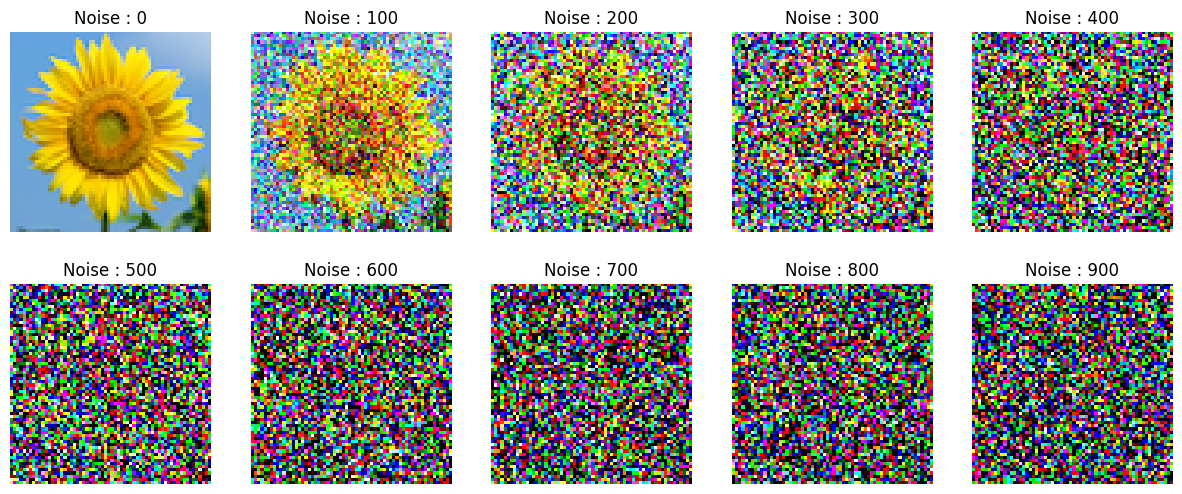

In [14]:
T = 1000 # time steps
beta_start = 0.0001
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, T) # noise parameter
imgs = []

for t  in range(T):
    if t % 100 == 0:
        img = reverse_to_img(x)
        imgs.append(img)

    beta = betas[t]
    eps = torch.randn_like(x) # noise
    x = torch.sqrt(1 - beta) * x + torch.sqrt(beta) * eps

# Show Images
fig = plt.figure(figsize=(15, 6))
for i, img in enumerate(imgs[:10]):
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Noise : {i * 100}")
plt.show()

### $q(x_t | x_0)$からのサンプリング

In [15]:
# 累積積

x = torch.tensor([1, 2, 3, 4])
output = torch.cumprod(x, dim=0)
print(output) # tensor([ 1,  2,  6, 24])

tensor([ 1,  2,  6, 24])


In [16]:
# Read Image
file_path = 'flower.png'
image = plt.imread(file_path)
print(image.shape)

(64, 64, 3)


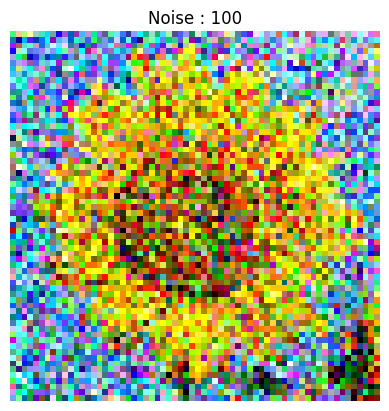

In [17]:
x = preprocess(image)

T = 1000 # time steps
beta_start = 0.0001
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, T) # noise parameter

def add_noise(x_0, t, betas):
    T = len(betas)
    assert t >= 1 and t <= T

    alphas = 1 - betas
    alpha_bars = torch.cumprod(alphas, dim=0)
    t_idx = t - 1
    alpha_bar = alpha_bars[t_idx]

    eps = torch.randn_like(x_0)
    x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * eps

    return x_t

# 時刻100でのノイズ画像
t = 100
x_t = add_noise(x, t, betas)

# 画像の表示
img = reverse_to_img(x_t)
plt.imshow(img)
plt.axis('off')
plt.title(f"Noise : {t}")
plt.show()

In [18]:
class Diffuser:
    def __init__(self, num_timesteps=1000, beta_start=0.0001, beta_end=0.02, device='cpu'):
        self.num_timesteps = num_timesteps
        self.device = device
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, device=device)

        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

    def add_noise(self, x_0, t):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= self.num_timesteps).all()
        t_idx = t - 1

        alpha_bar = self.alpha_bars[t_idx]
        N = alpha_bar.shape[0]
        alpha_bar = alpha_bar.view(N, 1, 1, 1)

        noise = torch.randn_like(x_0, device=self.device)
        x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * noise

        return x_t, noise

## 9.4 データ生成

In [19]:
import os
import torch
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import tqdm

In [20]:
class Diffuser:
    def __init__(self, num_timesteps=1000, beta_start=0.0001, beta_end=0.02, device='cpu'):
        self.num_timesteps = num_timesteps
        self.device = device
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, device=device)

        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

    def add_noise(self, x_0, t):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()
        t_idx = t - 1

        alpha_bar = self.alpha_bars[t_idx]
        N = alpha_bar.shape[0]
        alpha_bar = alpha_bar.view(N, 1, 1, 1)

        noise = torch.randn_like(x_0, device=self.device)
        x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * noise

        return x_t, noise
    
    def denoise(self, model, x, t):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()

        t_idx = t - 1
        alpha = self.alphas[t_idx]
        alpha_bar = self.alpha_bars[t_idx]
        alpha_bar_prev = self.alpha_bars[t_idx - 1]

        # 形状の変換
        N = alpha.size(0)
        alpha = alpha.view(N, 1, 1, 1)
        alpha_bar = alpha_bar.view(N, 1, 1, 1)
        alpha_bar_prev = alpha_bar_prev.view(N, 1, 1, 1)

        model.eval() # 出力:epsilon(x_t, t)，付加されたノイズの推定
        with torch.no_grad():
            eps = model(x, t)
        model.train() # モデルを訓練モードに戻す

        noise = torch.randn_like(x, device=self.device)
        noise[t == 1] = 0 # t=1のときはノイズを0にする

        mu = (x - ((1 - alpha) / torch.sqrt(1 - alpha_bar)) * eps) / torch.sqrt(alpha)
        std = torch.sqrt((1 - alpha) * (1 - alpha_bar_prev) / (1 - alpha_bar))
        return mu + std * noise
    
    def reverse_to_img(self, x):
        x = x * 255
        x = x.clamp(0, 255)
        x = x.to(torch.uint8)
        to_pil = transforms.ToPILImage()
        return to_pil(x)
    
    def sample(self, model, x_shape=(20, 1, 28, 28)):
        batch_size = x_shape[0]
        x = torch.randn(x_shape, device=self.device)

        for i in tqdm(range(self.num_timesteps, 0, -1)):
            t = torch.tensor([i] * batch_size, device=self.device, dtype=torch.long)
            x = self.denoise(model, x, t)

        images = [self.reverse_to_img(x[i]) for i in range(batch_size)]
        return images

## 拡散モデルの学習

In [21]:
import math
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn.functional as F
from torch import nn
from tqdm import tqdm

In [22]:
img_size = 28
batch_size = 128
num_timesteps = 1000
epochs = 10
lr = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def show_images(images, rows=2, cols=10):
    fig = plt.figure(figsize=(cols, rows))
    i = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, i+1)
            plt.imshow(images[i], cmap='gray')
            plt.axis('off')
            i += 1
    plt.show()

In [26]:
preprocess = transforms.ToTensor()
dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=preprocess)

dataLoader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

diffuser = Diffuser(num_timesteps=num_timesteps, device=device) # 拡散過程
model = UNet() # ノイズの推定モデル
model.to(device)
optimizer = Adam(model.parameters(), lr=lr)

100%|██████████| 1000/1000 [00:17<00:00, 57.12it/s]


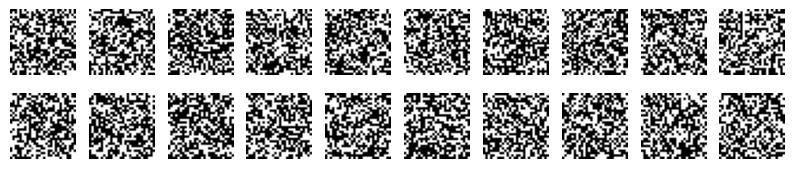

100%|██████████| 79/79 [00:13<00:00,  5.98it/s]


Epoch 1/10 |  Loss: 0.09479416534304619


100%|██████████| 1000/1000 [00:17<00:00, 58.81it/s]


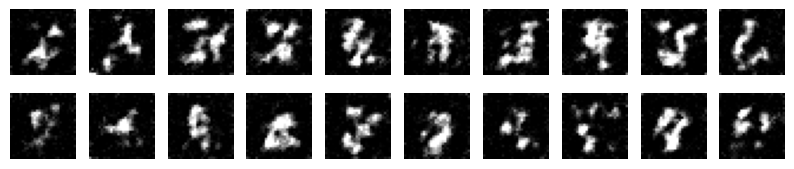

100%|██████████| 79/79 [00:13<00:00,  5.85it/s]


Epoch 2/10 |  Loss: 0.04116607254630403


100%|██████████| 1000/1000 [00:17<00:00, 57.88it/s]


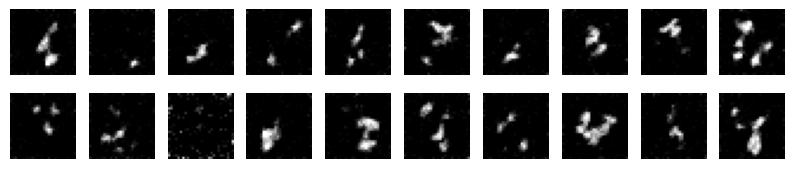

100%|██████████| 79/79 [00:13<00:00,  5.64it/s]


Epoch 3/10 |  Loss: 0.03547494948098931


100%|██████████| 1000/1000 [00:16<00:00, 59.06it/s]


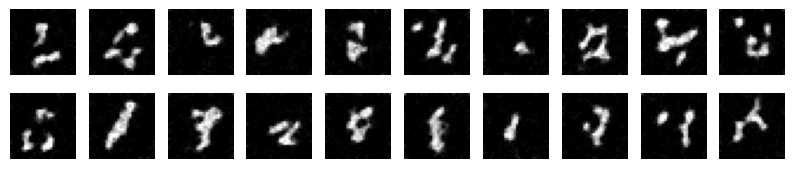

100%|██████████| 79/79 [00:13<00:00,  6.04it/s]


Epoch 4/10 |  Loss: 0.03406901740103583


100%|██████████| 1000/1000 [00:16<00:00, 59.49it/s]


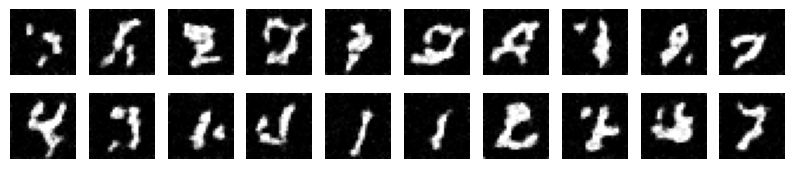

100%|██████████| 79/79 [00:13<00:00,  5.98it/s]


Epoch 5/10 |  Loss: 0.032140148049102556


100%|██████████| 1000/1000 [00:16<00:00, 58.93it/s]


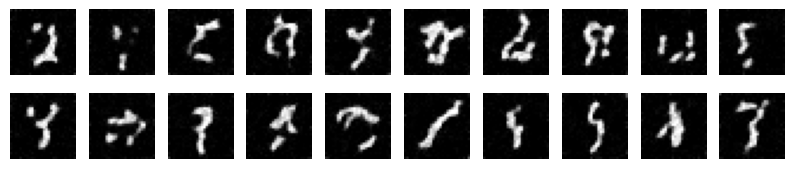

100%|██████████| 79/79 [00:13<00:00,  6.00it/s]


Epoch 6/10 |  Loss: 0.028755899235794816


100%|██████████| 1000/1000 [00:16<00:00, 58.84it/s]


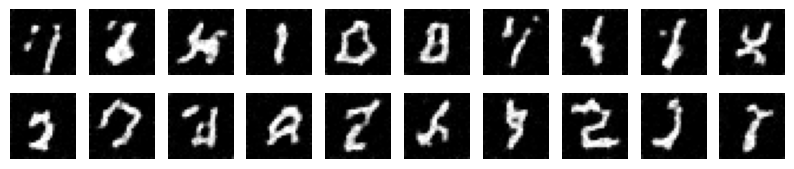

100%|██████████| 79/79 [00:13<00:00,  5.99it/s]


Epoch 7/10 |  Loss: 0.028458270067466967


100%|██████████| 1000/1000 [00:17<00:00, 58.78it/s]


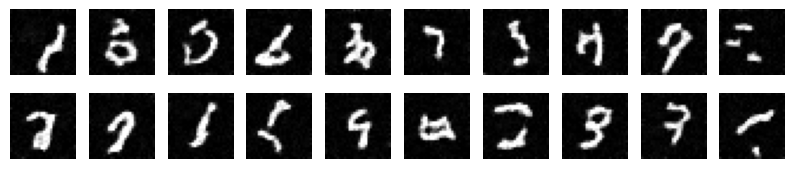

100%|██████████| 79/79 [00:14<00:00,  5.35it/s]


Epoch 8/10 |  Loss: 0.028737808235838443


100%|██████████| 1000/1000 [00:18<00:00, 53.32it/s]


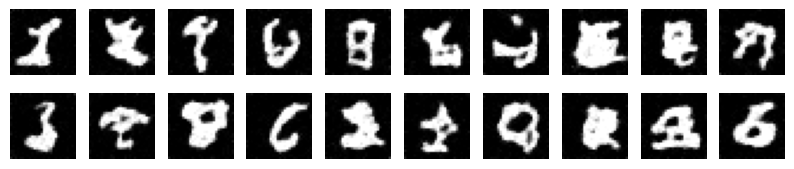

100%|██████████| 79/79 [00:13<00:00,  5.90it/s]


Epoch 9/10 |  Loss: 0.026601581044400795


100%|██████████| 1000/1000 [00:16<00:00, 58.94it/s]


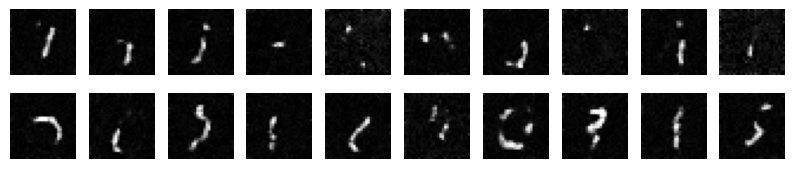

100%|██████████| 79/79 [00:13<00:00,  6.01it/s]

Epoch 10/10 |  Loss: 0.026890397661283046


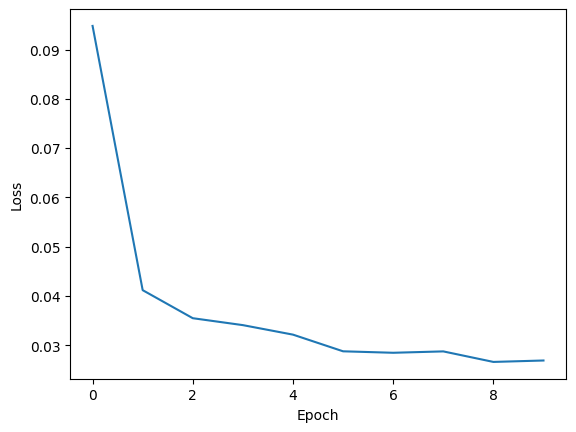

100%|██████████| 1000/1000 [00:16<00:00, 59.69it/s]


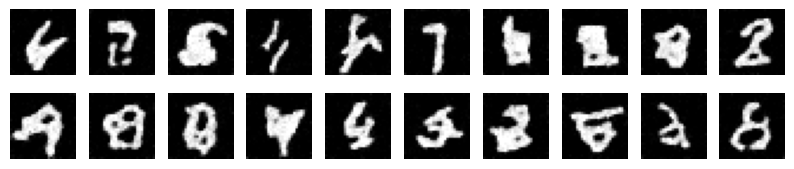

In [27]:
losses = []

for epoch in range(epochs):
    loss_sum = 0
    cnt = 0

    # epochごとにデータを生成して結果を確認
    images = diffuser.sample(model)
    show_images(images)

    for images, labels in tqdm(dataLoader):
        optimizer.zero_grad()
        x = images.to(device)
        t = torch.randint(1, num_timesteps+1, (len(x),), device=device) # 時刻tをランダムに選択（一様分布）

        x_noisy, noise = diffuser.add_noise(x, t) # x_t = sqrt(alpha_bar) * x_0 + sqrt(1 - alpha_bar) * epsilon(0, I)
        noise_pred = model(x_noisy, t)
        loss = F.mse_loss(noise_pred, noise)

        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        cnt += 1

    loss_avg = loss_sum / cnt
    losses.append(loss_avg)
    print(f"Epoch {epoch+1}/{epochs} |  Loss: {loss_avg}")

# Lossの推移
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# 生成画像の表示
images = diffuser.sample(model)
show_images(images)